# CS405_Lab6_CNN Architectures_and_Transfer_Learning


# TASKS FOR THE LAB:

There are two parts for this elaborate lab that you will have to carry out, but first and foremost the important instruction for the lab is to **listen to your instructor. It will help you understand and perform the lab easily.**

1. You will be preparing a report for answering the specific questions asked throughout this notebook. Please be attentive to avoid missing any such questions.
2. As the title suggests this lab is designed for you to learn to implement CNN architectures by yourselves and also use the pretrained architectures available to you thanks to the scientific community. The tasks for this part will appear to you as you scroll down the notebook.

Other than that, we are also going to learn the following very useful aspects of a deep learning project that are used very frequently:

* Tensorboard
  * Log data
  * Visualize the model
*   Checkpointing: Saving the optimizer, scheduler and other metrics along with the model for resuming training in the future

Note: Once you have completed the lab, consider retaining this notebook as your primary resource for any potential future utilization of the provided code, like for checkpointing or integrating with TensorBoard for various purposes

# Package installations and imports  

In [ ]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchsummary import summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!pip install --upgrade --no-cache-dir gdown

# Data Preparation

## Vegetable Dataset

For this lab, we will be using only the test set of the Vegetable Dataset as our working dataset consisting of only 3000 Images because today's lab is about using pretrained networks and how can we achieve good performance with them when we have less amounts of data. We will divide this data into train, validation and test sets (with a split of 70%, 15% and 15%, respectively. Another purpose of doing this is to perform quick train, validation and testing experiments with a small dataset.

Train: 2100

Val: 450

Test: 450

https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

## Download and unzip the dataset

In [ ]:
# download test_set
!gdown https://drive.google.com/file/d/1aXaH7F6iNlK2mqzZBY_mMF5uazwQHM7W/view?usp=sharing --fuzzy

In [ ]:
%%capture
!unzip /content/vegetable_test.zip;

## Loading the train, val and test sets from their respective folders

### Initializing ImageFolder (dataset) Instances

In [ ]:
image_size = 224
batch_size = 64

In this lab, we will learn about using pre-trained models.

In order to quickly execute training loops and prove that using pretrained models help us achieve good results with less amounts of data we will use split the test set of the vegetable dataset as the train_set, val_set and test_set.

## Question 1: What does the torchvision.transforms.Compose() function do in the cell below?

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((image_size,image_size))])

## Question 2: What is the torchvision.datasets.ImageFolder() method used for in the cell below? What are its arguments?

In [ ]:
# path to our datset
data_path = '/content/vegetable_test'

#Initialize the dataset instance from the given datapath
data_set = torchvision.datasets.ImageFolder(root=data_path, transform=transform)

In [ ]:
#Side note: you can access transform of a dataset object like this:
data_set.transform

In [ ]:
# Split the dataset into train, validation and test splits
train_set, val_set, test_set = torch.utils.data.random_split(data_set, [2100, 450, 450], generator=torch.Generator().manual_seed(42))

In [ ]:
#Side note: For subset of the data_set like train_set, you can access its transform like this:
train_set.dataset.transform

In [ ]:
# Class to number of instances
# caution: takes some time to complete for large datasets
total = 0
class_counts = np.zeros(len(train_set.dataset.classes))
for image, label in train_set:
    class_counts[label] += 1
    total +=1
for i in range(len(class_counts)):
  print("class:%s, instances: %d"%([k for k,v in train_set.dataset.class_to_idx.items() if v == i], class_counts[i]))

## Question 3: What is the if-elif condition used for in the cell below?

In [ ]:
# Print the classes in the dataset
classes = None
if hasattr(train_set, 'classes'):
      classes = train_set.classes
elif hasattr(train_set, 'dataset') and hasattr(train_set.dataset, 'classes'):
      classes = train_set.dataset.classes

classes

## Function for visualizing images of dataset object

In [ ]:
def show_dataset_samples(data_set):
    loader = torch.utils.data.DataLoader(
    data_set,
    batch_size=32,
    shuffle=True)

  # Get a batch of images from the train_loader
    images, labels = next(iter(loader))

    rows = col = 3
    #fig, axes = plt.subplots(nrows=5, ncols=5)                          )
    plt.figure(figsize = (10,10))

    for i in range(rows*col):
      # Plot a random image from the batch
      random_index = np.random.randint(0, images.shape[0])
      image = images[random_index]
      label = labels[random_index]
      plt.subplot(rows, col, i+1)
      plt.axis('off')
      plt.imshow(image.permute(1,2,0))

      if hasattr(train_set, 'classes'):
        classes = train_set.classes
      elif hasattr(train_set, 'dataset') and hasattr(train_set.dataset, 'classes'):
        classes = train_set.dataset.classes

      plt.title(f'Label: {classes[label]}')

In [ ]:
show_dataset_samples(train_set)

## Compute standardization parameters and apply

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c

## Question 4: Why are we calculating the mean and std of only the trian_set in the cell below? Why not calculate for the whole dataset?

In [ ]:
# Create a dummy dataloader for our train_set
dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32)
# Call the function and compute mean and std
mean, std = get_mean_and_std(dataloader)
print(mean, std)

In [ ]:
# Add the new normalization to the existing transforms
normalize = torchvision.transforms.Normalize(mean=mean, std=std)
transform = torchvision.transforms.Compose([transform, normalize])

## Question 5: How are we updating the transforms of our subsets in the cell below?

In [ ]:
# A function for updating the transforms of our dataset objects
def update_transform(dataset, transform):
    if hasattr(dataset, 'transform'):
      dataset.transform = transform
      dataset.transform
    elif hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'transform'):
      dataset.dataset.transform = transform
      dataset.dataset.transform
    else:
      print("No transform attribute found.")

In [ ]:
# Add the normalization transform to the datasets
# using the "update_transform" function
update_transform(train_set, transform)
update_transform(val_set, transform)
update_transform(test_set, transform)

In [ ]:
### Visualize the images with the new normalization transform
show_dataset_samples(train_set)

## Data Augmentation

## Question 6: What transforms are we using in the cell below?
## Question 7: Why are we only applying them to the train_set?

In [ ]:
# composing transforms instance for data augmentation
augmentation_transforms = torchvision.transforms.Compose([transform,
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.GaussianBlur(5)
    ])

# Add the augmentation_transfomers to the train_set
update_transform(train_set, transform)

## Initializing the pytorch dataloaders and visualize train examples

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)


# Convolutional Neural Networks Architectures

# TASKS
# You have two tasks to perform in this lab:

## Task 1:
In the cells below the VGG16 model has been manually implemented for you to initialize a VGG16 model with random variables. You have also been provided code for using a pretrained VGG16 model.

1. You to first train the manually implemented model for 15 epochs, save its training and validation plots and evaluate it on the test set.

2. Then, using the provided code, fine-tune the pre-trained model for a 3 epochs, save its training and validation plots and evaluate it on the test set.  

Compare the performance and traning plots of the pre-trained model with those of the model trained from scratch. Report and discuss your observations in the Lab Report for both models.

## Task 2:
Train a pretrained ResNet-50 model on the same dataset for a few epochs 2-3 epochs, save its plots, evaluate it on the test set and compare its performance with that of the pre-trained VGG-16 model. Report and discuss your observations.



## Question 8: Instead of fine-tuning the pre-trained model for a few epochs what would happen if we train the pre-trained model for a large number of epochs on the train_set?

## VGG-16 Manual Implementation and Random Initialization
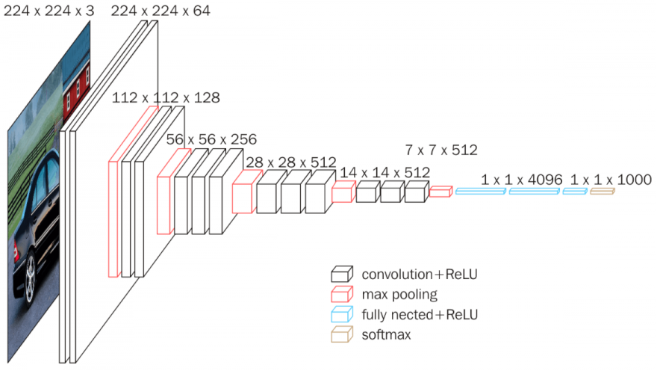

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=15, im_height=224, im_width=224):

        super(VGG16, self).__init__()

        max_pool_count = 5
        size_reduction_factor = 2**max_pool_count
        out_height = im_height // size_reduction_factor
        out_width = im_width // size_reduction_factor

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(out_height*out_width*512, 4096),
            nn.ReLU())

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Source: https://blog.paperspace.com/vgg-from-scratch-pytorch/

In [ ]:
model = VGG16()

# Torchvision Pretrained VGG16 Model

In [ ]:
# https://pytorch.org/vision/stable/models.html
model = torchvision.models.vgg16(pretrained= True)

# Alternate method of initialization:
# modelVGG = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights)

The "parameters()" attribute of a model returns us a generator that iteratively provides us the parameters of each layer of the model.

In the code below, we use a for loop to iterate over the parameters of each layer in the model.

The requires_grad flag for parameters of a layer signifies whether to calculate the gradients for those parameters when doing a backward pass. So initially we set requires_grad to false for parameters of all the layers

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model

### Replace an exisiting layer in model (VGG19)

The VGG19 model is divided into two sequential parts: First one is the "features" module and the second one is the classifer module. The "features" module consists of all the 2D opertation layers and the "classifier" module consists of all the fully connected layers.

In our case, the vegetable dataset has 15 classes, so we initialize a new layer and replace the last linear layer of the classifier that has 1000 outputs for 1000 classes of imagenet with the new layer with 15 outputs.


In [ ]:
model.classifier[-1] = nn.Linear(in_features=4096, out_features= 15)

# Model Configuration

## Loss Function and Optimizer Selection

In [ ]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 10

model.to(device);


# Training

## Function for running the model over all the samples of a given dataloader object

In [ ]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):

  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0

  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)

  # number of batches we can get by the loader
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):

    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)

    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()

    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows

    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)

    # Backpropagation
    if train:
      loss.backward()

    # Update the parameters using the gradients
    if train:
      optimizer.step()

    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  return loss, accuracy

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []


val_accuracy_max = -1

checkpoint_path = '/content/checkpoint.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint.pth'

# Start epoch is zero for new training
start_epoch = 0

## Setting up Tensorboard

## Question 9: What do you observe in the cells given below related to Tensorboard? Please discuss in the report. How do you enable the tensorboard in the colab environment like this one?

In [ ]:
import tensorboard
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# A command starting with % is called a magic command
# This command is used for loading the tensorboard extension for
# enabling it to be able to run in this colab notebook
%load_ext tensorboard

# Otherwise when it is installed in your PC the tensorboard is run through the
# browser. Once it is run, you use the provided address to access it through
# a browser on your PC.

In [ ]:
# Initialize the SummaryWriter instance. The default log_dir is set to runs/
# Here we have speified our own log directory
writer = SummaryWriter(log_dir="/content/runs/")

In [ ]:
sample_images, labels = next(iter(train_loader))

# The add_graph method is used to visualize the model
# We provide the model and sample image
writer.add_graph(model, sample_images.to(device))

### Note: Once the tesnorboard interface is showing and the training has been started, you may click on the referesh button to start visualizing the training curves.

In [ ]:
# The % sign is the magic command for the tensorboard to run in colab
#
%tensorboard --logdir /content/runs/

# For more details:
# https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

## Main training loop

## Question 10: How is modularity introduced in the over training of our model in this notebook? What does run_1_epoch() actually do in this case?   

## Question 11: How are we logging Tensorboard values in the cell below? Are you observing the training plots during the training of your the implemented VGG16 model?

## Question 12: Please discuss about the checkpointing in the cell below. How is it implemented?

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)

  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))

  # Save model if validation accuracy for current epoch is greater than
  # all the previous epochs
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)
  writer.flush()


In [ ]:
# Copy best model to drive
# You may also directly save the best model to drive during training

!cp /content/best_val_checkpoint.pth /content/drive/MyDrive/Machvis/Labs/trained_models

**Accuracy and Loss Result Graphs:**

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train_accuracy")
plt.plot(val_accuracy_list, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

# Evaluating the Model

**Loading the best saved model:**

In [ ]:
best_val_model_path = '/content/best_val_checkpoint.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))

In [ ]:
# Before loading the state_dict of the model, make sure the "model" instance is
# initiated by its corresponding class e.g. VGG16
model.load_state_dict(best_val_checkpoint['model'])

In [ ]:
with torch.no_grad():
    test_loss, test_accuracy  = run_1_epoch(model, loss_function, test_loader, train= False)

print('test loss: %.4f'%(test_loss))
print('test_accuracy %.2f' % (test_accuracy))


In [ ]:
# Get a batch of images from the train_loader
images, labels = next(iter(test_loader))

with torch.no_grad():
  predicted_labels = model(images.to(device))
  predicted_labels = torch.argmax(predicted_labels, 1)
rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5))
plt.figure(figsize = (10,10))

for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  pred_label = predicted_labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  plt.title(f'Label: {classes[label]}, Pred: {classes[pred_label]}')

### Useful repositories for gradcam and visualizations.
https://github.com/jacobgil/pytorch-grad-cam

https://github.com/utkuozbulak/pytorch-cnn-visualizations


# Notebook Source
https://github.com/Vision-At-SEECS/Pytorch_Labs/blob/main/Lab3_Transfer_Learning_and_GradCAM.ipynb

You may explore other notebooks in the link of the repository given above.

